In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from package.utils import KPIPoint
from package.utils import KPISet
from package.utils import Transformer
from package.HotSpot import HotSpot
from package.utils import Evalutaion

#### 加载第一周数据

In [2]:
# timestamp_strat = 1535731200
# timestamp_end = 1536335700 #1535731200 + 5 * 60#
# timestamp_interval = 5 * 60
# file_path = '../2019AIOps_data/'
# kSet_train = Transformer().transformKPIData2KPISet(file_path, timestamp_strat, timestamp_end, timestamp_interval)
# kSet_train.save('../result/metadata/KPISetTrain')
kSet_train = KPISet({}, {})
kSet_train.load('../result/metadata/KPISetTrain')

#### 加载第二周数据（注入了异常）

In [3]:
# timestamp_strat = 1536336000
# timestamp_end = 1536940500 #1536336000 + 5 * 60# 
# timestamp_interval = 5 * 60
# file_path = '../2019AIOps_data_valid/'
# kSet_valid = Transformer().transformKPIData2KPISet(file_path, timestamp_strat, timestamp_end, timestamp_interval)
# kSet_valid.save('../result/metadata/KPISetValid')
kSet_valid = KPISet({}, {})
kSet_valid.load('../result/metadata/KPISetValid')

#### 使用第一周数据预测第二周数据，此处可以优化

In [ ]:
# 使用第一周数据预测第二周数据
I = 300
T = I * 288 * 7
train_timestamp_start = 1535731200
train_timestamp_end = 1536335700
for timestamp in tqdm(kSet_valid._KPIPoints):
    tw = math.floor((timestamp - 16 * 3600) % (3600 * 24) / I)
    # print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(timestamp)), tw)
    for leaf in kSet_valid._KPIPoints[timestamp]._leaf:
        ts_true = kSet_train.get_ts_leaf(leaf=leaf, 
                                         t1=train_timestamp_start + tw * I,
                                         t2=train_timestamp_end, 
                                         delta=T)['true']
        predict = np.mean(ts_true)
        kSet_valid._KPIPoints[timestamp]._leaf[leaf][1] = predict

#### 保存数据
kSet_valid.save('../result/metadata/KPISetValidPredict2')

#### 预测效果评估

MAE 225.728895272


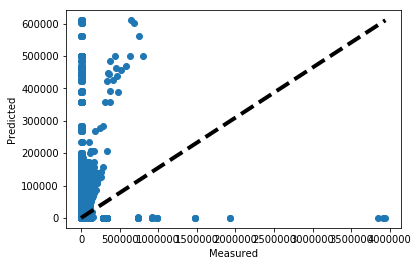

In [2]:
# 加载数据集
kSet_valid = KPISet({}, {})
kSet_valid.load('../result/metadata/KPISetValidPredict2')

# 获取真实值和预测值的列表
real = []
pred = []
for ts in kSet_valid._KPIPoints:
    for leaf in kSet_valid._KPIPoints[ts]._leaf:
        value = kSet_valid._KPIPoints[ts]._leaf[leaf]
        real.append(value[0])
        pred.append(value[1])

R2 0.344720053493


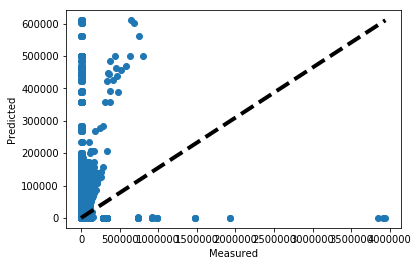

In [13]:
eva = Evalutaion()
eva.evaluate(real, pred, 'R2')
eva.visualize(real, pred)

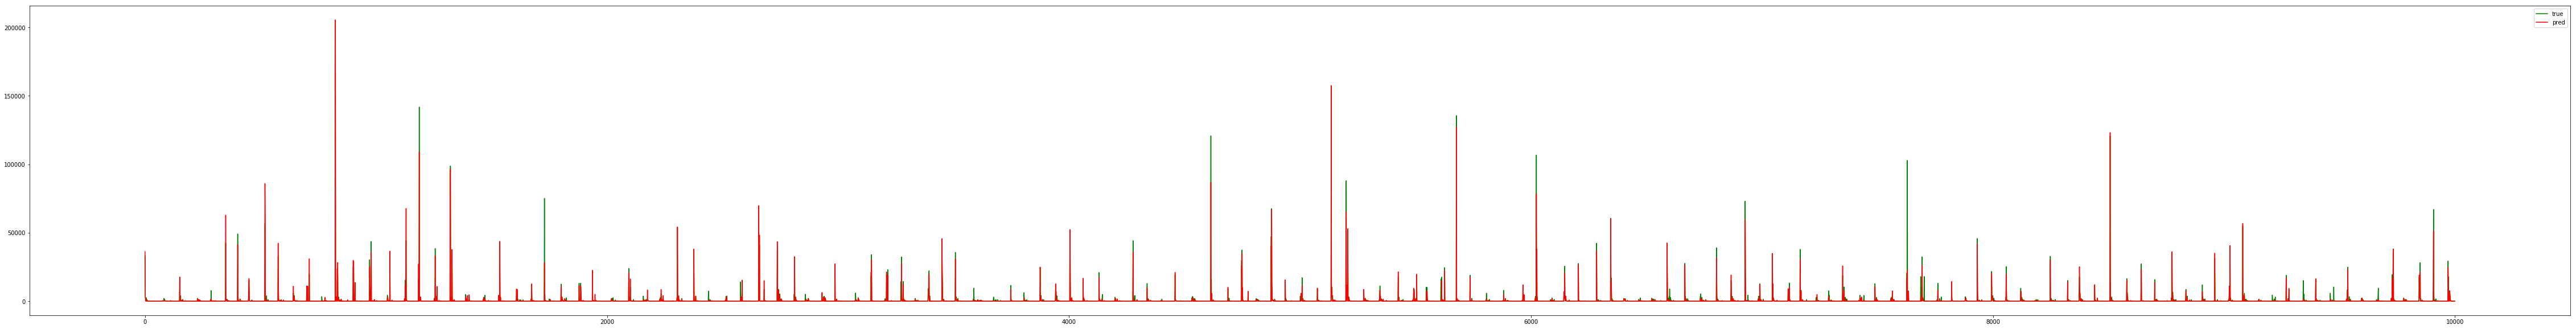

In [12]:
np.max(real), np.max(pred)
plt.figure(figsize=(80, 10))
plt.plot(real[:10000], 'g', label='true')
plt.plot(pred[:10000], 'r', label='pred')
plt.legend(loc='best')
plt.show()

#### 异常定位

In [ ]:
# 加载数据集
# kSet_valid = KPISet({}, {})
# kSet_valid.load('../result/metadata/KPISetValidPredict')

# 读取异常时间戳，注意该文件带有Header——timestamp
root_cause_set = pd.read_csv('../Anomalytime_data_valid.csv')
root_cause_set = root_cause_set.sort_values(by='timestamp').reset_index(drop=True)
outlier = root_cause_set['timestamp'].tolist()

# HotSpot参数
ps_threshold = 0.98  # 潜在得分阈值
ep_threshold = 0.01  # 解释力阈值
max_iter = 10  # MCTS最大迭代次数

res = {}
res['timestamp'] = []
res['set'] = []
sTime = time.time()
for timestamp in tqdm(outlier):
    ts = timestamp / 1000
    kPoint = kSet_valid._KPIPoints[ts]
    layer_max = len(kPoint._attribute_names)
    hotSpot = HotSpot(kPoint, layer_max, ps_threshold, ep_threshold, max_iter)
    rootCauseSet = hotSpot.find_root_cause_set_revised()
    res['timestamp'].append(timestamp)
    sets = []
    for ele in rootCauseSet[0][0]:
        sets.append("&".join(ele))
    res['set'].append(';'.join(sets))
eTime = time.time()
print('runtime %fs' % (eTime - sTime))
res = pd.DataFrame(res)
resPath = '../result/submit_valid_%s.csv' % time.strftime("%Y%m%d%H%M%S", time.localtime(eTime))
res.to_csv(resPath, index=False)

### 评估

In [ ]:
def isset(v):
    try:
        type (eval(v))
    except:
        return 0
    else:
        return 1
    
def transformRootCauseSet(string):
    root_cause_set = []
    sets = string.split(';')
    for s in sets:
        elements = s.split('&')
        root_cause_set.append(elements)
    return root_cause_set
resPath = resPath if isset('resPath') else '../result/submit_valid.csv'
result = pd.read_csv(resPath)
result = result.sort_values(by='timestamp').reset_index(drop=True)
result['set'] = result['set'].apply(transformRootCauseSet)
result = result.merge(root_cause_set, on='timestamp', how='left')
result.to_csv('../result/root_cause_set_valid_%s.csv' % time.strftime("%Y%m%d%H%M%S", time.localtime(time.time())), 
              index=False)
result.head()

#### 计算F-score

In [ ]:
TP = 0
FN = 0
FP = 0
for ts in result['timestamp'].tolist():
    root_cause = result[result['timestamp']==ts]['real_set']
    root_cause_cal = result[result['timestamp']==ts]['set']
    tmp = 0
    for s1 in root_cause:
        for s2 in root_cause_cal:
            if len(s1) == len(s2) and len(set(s1).intersection(set(s2))) == len(s1):
                tmp += 1
                break
    TP += tmp
    FN += len(root_cause) - tmp
    FP += len(root_cause_cal) - tmp
if TP == 0:
    TP += 1
print(TP, FP, FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
FScore = (2 * Precision * Recall)/(Precision + Recall)
print('F-score = %f' % FScore)